In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具

## 預測目標
以一週後（五個交易日）的漲跌作為預測目標

## 資料視覺化
為了進行 logistic regression，先嘗試用圖表分類

以一週後的漲跌情況作分類

不過找不到可將這兩群分開的 feature

所以預測進行 logistic regression 應該不會有好結果

             Date  Open Price  Close Price  High Price  Low Price      Volume
0     02-Jan-2009      902.99       931.80      934.73     899.35  4048270080
1     05-Jan-2009      929.17       927.45      936.63     919.53  5413910016
2     06-Jan-2009      931.17       934.70      943.85     927.28  5392620032
3     07-Jan-2009      927.45       906.65      927.45     902.37  4704940032
4     08-Jan-2009      905.73       909.73      910.00     896.81  4991549952
...           ...         ...          ...         ...        ...         ...
2259  22-Dec-2017     2684.22      2683.34     2685.35    2678.13  1383888512
2260  26-Dec-2017     2679.09      2680.50     2682.74    2677.96  1103808384
2261  27-Dec-2017     2682.10      2682.62     2685.64    2678.91  1149108352
2262  28-Dec-2017     2686.10      2687.54     2687.66    2682.69  1126089856
2263  29-Dec-2017     2689.15      2673.61     2692.12    2673.61  1332374016

[2264 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
R

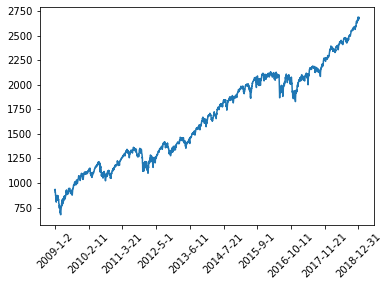

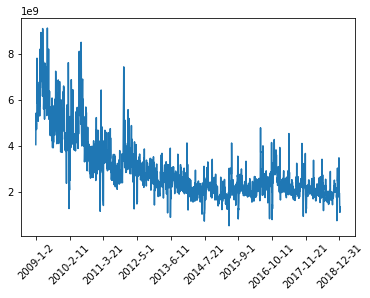

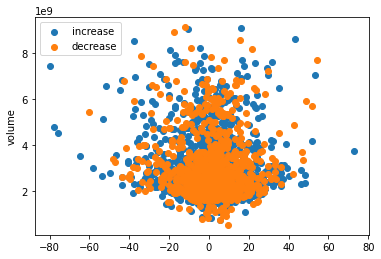

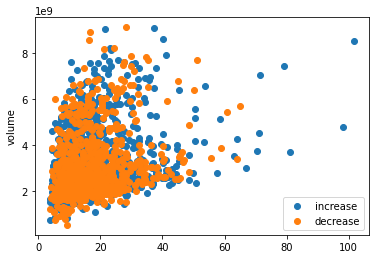

In [2]:
df = pd.read_csv('train.csv') 
print(df)
df.info()
train_set = df[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume']]
df1 = pd.read_csv('test.csv')
df1.info()
test_set = df1[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume']]

# 股價變化
x_axis = np.linspace(0, 2264, 2264)
plt.xticks(range(0, 2264, (int)(2264/9)), ['2009-1-2','2010-2-11','2011-3-21','2012-5-1','2013-6-11',
                      '2014-7-21','2015-9-1','2016-10-11','2017-11-21','2018-12-31'], rotation=45)
plt.plot(x_axis, train_set['Close Price'])
plt.show()
# volume 變化
plt.xticks(range(0, 2264, (int)(2264/9)), ['2009-1-2','2010-2-11','2011-3-21','2012-5-1','2013-6-11',
                      '2014-7-21','2015-9-1','2016-10-11','2017-11-21','2018-12-31'], rotation=45)
plt.plot(x_axis, train_set['Volume'])
plt.show()
#plt.scatter(train_set['Close Price'], train_set['Volume'])
#plt.show()
#diff = np.linspace(0, 2264, 2264)
#for i in range(0, 2264):
#    diff[i] = train_set['Open Price'][i] - train_set['Close Price'][i]
#plt.scatter(diff[0:200], train_set['Volume'][0:200])
#plt.show()
#diff = np.linspace(0, 2264, 2264)
#for i in range(0, 2264):
#    diff[i] = train_set['High Price'][i] - train_set['Low Price'][i]
#plt.scatter(diff[1500:2000], train_set['Volume'][1500:2000])
#plt.show()
# 將漲和跌分開繪製
trend = np.zeros(2258)
for i in range(0, 2258):
    trend[i] = train_set['Close Price'][i + 6] - train_set['Close Price'][i + 1]
diff = np.zeros(2258)
# 昨天和當天收盤價差
for i in range(0, 2258):
    diff[i] = train_set['Close Price'][i + 1] - train_set['Close Price'][i]
new_set = train_set['Volume'][1:2259]
plt.scatter(diff[trend > 0], new_set[trend > 0])
plt.scatter(diff[trend < 0], new_set[trend < 0])
plt.legend(['increase', 'decrease'])
plt.ylabel('volume')
plt.xlabel('')
plt.show()
# amplitude
amp = np.zeros(2258)
# 當日振幅
for i in range(0, 2258):
    amp[i] = train_set['High Price'][i + 1] - train_set['Low Price'][i + 1]
plt.scatter(amp[trend > 0], new_set[trend > 0])
plt.scatter(amp[trend < 0], new_set[trend < 0])
plt.legend(['increase', 'decrease'])
plt.ylabel('volume')
plt.xlabel('')
plt.show()

## preprocessing
訓練資料中沒有缺失值

離群值可能反映重大市場變化因此不處理

所以只針對資料 normalize

In [3]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
# training set
normalizer.fit(train_set['Volume'].to_numpy().reshape(-1, 1))
train_set['Volume'] = normalizer.transform(train_set['Volume'].to_numpy().reshape(-1, 1))
normalizer.fit(train_set['Open Price'].to_numpy().reshape(-1, 1))
train_set['Open Price'] = normalizer.transform(train_set['Open Price'].to_numpy().reshape(-1, 1))
normalizer.fit(train_set['Close Price'].to_numpy().reshape(-1, 1))
train_set['Close Price'] = normalizer.transform(train_set['Close Price'].to_numpy().reshape(-1, 1))
normalizer.fit(train_set['High Price'].to_numpy().reshape(-1, 1))
train_set['High Price'] = normalizer.transform(train_set['High Price'].to_numpy().reshape(-1, 1))
normalizer.fit(train_set['Low Price'].to_numpy().reshape(-1, 1))
train_set['Low Price'] = normalizer.transform(train_set['Low Price'].to_numpy().reshape(-1, 1))
# test set
normalizer.fit(test_set['Volume'].to_numpy().reshape(-1, 1))
test_set['Volume'] = normalizer.transform(test_set['Volume'].to_numpy().reshape(-1, 1))
normalizer.fit(test_set['Open Price'].to_numpy().reshape(-1, 1))
test_set['Open Price'] = normalizer.transform(test_set['Open Price'].to_numpy().reshape(-1, 1))
normalizer.fit(test_set['Close Price'].to_numpy().reshape(-1, 1))
test_set['Close Price'] = normalizer.transform(test_set['Close Price'].to_numpy().reshape(-1, 1))
normalizer.fit(test_set['High Price'].to_numpy().reshape(-1, 1))
test_set['High Price'] = normalizer.transform(test_set['High Price'].to_numpy().reshape(-1, 1))
normalizer.fit(test_set['Low Price'].to_numpy().reshape(-1, 1))
test_set['Low Price'] = normalizer.transform(test_set['Low Price'].to_numpy().reshape(-1, 1))

# 振幅
amp = np.zeros(2258)
# 收盤價差
diff = np.zeros(2258)

for i in range(0, 2258):
    trend[i] = train_set['Close Price'][i + 6] - train_set['Close Price'][i + 1]
for i in range(0, 2258):
    diff[i] = train_set['Close Price'][i + 1] - train_set['Close Price'][i]
for i in range(0, 2258):
    amp[i] = train_set['High Price'][i + 1] - train_set['Low Price'][i + 1]
    
# test set 
t_amp = np.zeros(246)
t_diff = np.zeros(246)
t_trend = np.zeros(246)
for i in range(0, 246):
    t_trend[i] = test_set['Close Price'][i + 6] - test_set['Close Price'][i + 1]
for i in range(0, 246):
    t_diff[i] = test_set['Close Price'][i + 1] - test_set['Close Price'][i]
for i in range(0, 246):
    t_amp[i] = test_set['High Price'][i + 1] - test_set['Low Price'][i + 1]

    
volume = train_set['Volume'][1:2259].to_numpy().reshape(-1, 1)
trend = trend.reshape(-1, 1)
diff = diff.reshape(-1, 1)
amp = amp.reshape(-1, 1)

# test set
t_volume = test_set['Volume'][1:247].to_numpy().reshape(-1, 1)
t_trend = t_trend.reshape(-1, 1)
t_diff = t_diff.reshape(-1, 1)
t_amp = t_amp.reshape(-1, 1)

print(volume.shape)
print(trend.shape)
print(diff.shape)
print(amp.shape)

trend_n = trend.copy()
for i in range(2258):
    if trend[i] > 0:
        trend_n[i] = 1
    else :
        trend_n[i] = -1

t_trend_n = t_trend.copy()
# test set
for i in range(246):
    if t_trend[i] > 0:
        t_trend_n[i] = 1
    else :
        t_trend_n[i] = -1


/home/sdcaramel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sdcaramel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sdcaramel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

(2258, 1)
(2258, 1)
(2258, 1)
(2258, 1)


## logistic regression
使用 logistic regression

出來的結果和一開始猜的差不多

accuracy 只有大約 50 多 %

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 

data = np.zeros((2258, 2))
for i in range(0, 2258):
    data[i][0] = volume[i]
    data[i][1] = diff[i]
    
t_data = np.zeros((246, 2))
for i in range(0, 246):
    t_data[i][0] = t_volume[i]
    t_data[i][1] = t_diff[i]
    
kf = KFold(n_splits=5,                                # 設定 K 值
              random_state=0,
              shuffle=True)
kf.get_n_splits(data)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

model = LinearRegression() 

for train_index, valid_index in kf.split(data):    # 每個迴圈都會產生不同部份的資料
    train_x_split = data[train_index]         # 產生訓練資料
    train_y_split = trend[train_index]         # 產生訓練資料標籤
    valid_x_split = data[valid_index]         # 產生驗證資料
    valid_y_split = trend[valid_index]         # 產生驗證資料標籤

    for i in range(len(train_y_split)):
        if train_y_split[i] > 0:
            train_y_split[i] = 1
        else :
            train_y_split[i] = -1
    for i in range(len(valid_y_split)):
        if valid_y_split[i] > 0:
            valid_y_split[i] = 1
        else :
            valid_y_split[i] = -1
       
    model.fit(train_x_split, train_y_split)           

    train_pred_y = model.predict(train_x_split)       # 確認模型是否訓練成功
    for i in range(len(train_pred_y)):
        if train_pred_y[i] > 0:
            train_pred_y[i] = 1
        else :
            train_pred_y[i] = -1
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                                   train_pred_y)
    valid_pred_y = model.predict(valid_x_split)       # 驗證模型是否訓練成功
    for i in range(len(valid_pred_y)):
        if valid_pred_y[i] > 0:
            valid_pred_y[i] = 1
        else :
            valid_pred_y[i] = -1
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                                   valid_pred_y)

    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print('training set')
print((
'average train accuracy: {}\n' +
'    min train accuracy: {}\n' +
'    max train accuracy: {}\n' +
'average valid accuracy: {}\n' +
'    min valid accuracy: {}\n' +
'    max valid accuracy: {}').format(
np.mean(train_acc_list),                          # 輸出平均訓練準確度
np.min(train_acc_list),                           # 輸出最低訓練準確度
np.max(train_acc_list),                           # 輸出最高訓練準確度
np.mean(valid_acc_list),                          # 輸出平均驗證準確度
np.min(valid_acc_list),                           # 輸出最低驗證準確度
np.max(valid_acc_list)                            # 輸出最高驗證準確度
))

print('test set')
pred = model.predict(t_data)
for i in range(len(pred)):
    if pred[i] > 0:
        pred[i] = 1
    else :
        pred[i] = -1
test_acc = accuracy_score(pred, t_trend_n)
print(test_acc)


training set
average train accuracy: 0.5983172981165285
    min train accuracy: 0.5899280575539568
    max train accuracy: 0.6048699501936912
average valid accuracy: 0.5983203500578851
    min valid accuracy: 0.5720620842572062
    max valid accuracy: 0.6319290465631929
test set
0.532520325203252


## neural network
嘗試用 skilearn 的 MLPClassifier

結果和 logistic regression 差不多

In [5]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=0,
              solver='lbfgs')
clf.fit(train_set[1:2259], trend_n)

pred = clf.predict(train_set[1:2259])
for i in range(len(pred)):
    if pred[i] > 0:
        pred[i] = 1
    else :
        pred[i] = -1
acc = accuracy_score(pred, trend_n)
print('training set accuracy')
print(acc)

t_pred = clf.predict(test_set[1:247])
for i in range(len(t_pred)):
    if t_pred[i] > 0:
        t_pred[i] = 1
    else :
        t_pred[i] = -1
t_acc = accuracy_score(t_pred, t_trend_n)
print('test set accuracy')
print(t_acc)

training set accuracy
0.5983170947741364
test set accuracy
0.540650406504065


/home/sdcaramel/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## LSTM (Long Short-Term Memory)
考慮到股票趨勢和時間相關性

嘗試用 lstm 來預測

以五天為一個區間預測下週的走勢

參考資料：https://ithelp.ithome.com.tw/articles/10195400

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

np.random.seed(0)

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(1, len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

train_x, train_y = create_dataset(train_set.values, 5)
test_x, test_y = create_dataset(test_set.values, 5)
train_y_n = np.zeros(2258)
for i in range(2258):
    train_y_n[i] = train_y[i][1]
#train_x = np.reshape(train_x, (train_x.shape[0] * 5, 1, train_x.shape[1]))
#test_x = np.reshape(test_x, (test_x.shape[0] * 5, 1, test_x.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(5, 5)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y_n, epochs=10, batch_size=1, verbose=2, shuffle=False)

train_predict = model.predict(train_x)
test_predict = model.predict(test_x)



Using TensorFlow backend.


Epoch 1/10
 - 8s - loss: 0.1005
Epoch 2/10
 - 8s - loss: 0.0067
Epoch 3/10
 - 8s - loss: 0.0030
Epoch 4/10
 - 8s - loss: 0.0022
Epoch 5/10
 - 8s - loss: 0.0018
Epoch 6/10
 - 8s - loss: 0.0016
Epoch 7/10
 - 7s - loss: 0.0015
Epoch 8/10
 - 7s - loss: 0.0014
Epoch 9/10
 - 7s - loss: 0.0014
Epoch 10/10
 - 8s - loss: 0.0013


In [7]:
print(len(train_predict))
print(len(test_predict))

2258
246


## 結果
預測出來的曲線走勢和真實的差不多

算出預測的股價曲線的漲跌和真實的作比較

發現準確率高出前兩種方法很多

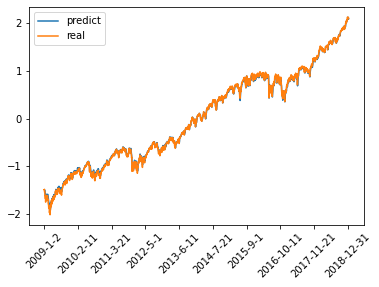

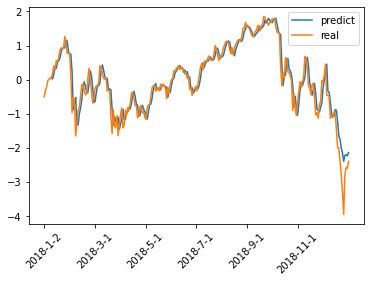

train
0.7719220549158547
test
0.8130081300813008


In [8]:
x_axis = np.linspace(0, 2264, 2264)
y_axis = np.linspace(0, 252, 252)

plt.xticks(range(0, 2264, (int)(2264/9)), ['2009-1-2','2010-2-11','2011-3-21','2012-5-1','2013-6-11',
                      '2014-7-21','2015-9-1','2016-10-11','2017-11-21','2018-12-31'], rotation=45)
plt.plot(x_axis[6:2264], train_predict)
plt.plot(x_axis, train_set['Close Price'])
plt.legend(['predict','real'])
plt.show()
plt.xticks(range(0, 252, (int)(252/6)), ['2018-1-2','2018-3-1','2018-5-1','2018-7-1',
                          '2018-9-1','2018-11-1','2018-12-31'], rotation=45)
plt.plot(y_axis[6:252], test_predict)
plt.plot(y_axis, test_set['Close Price'])
plt.legend(['predict','real'])
plt.show()

lstm_trend = np.zeros(2258)
for i in range(-5, 2253):
    if i >= 0:
        lstm_trend[i + 5] = train_predict[i + 5] - train_predict[i]
    else :
        lstm_trend[i + 5] = train_predict[5] - train_predict[0]
lstm_trend_t = np.zeros(246)
for i in range(-5, 241):
    if i >= 0:
        lstm_trend_t[i + 5] = test_predict[i + 5] - test_predict[i]
    else :
        lstm_trend_t[i + 5] = test_predict[i + 5] - test_predict[i]

for i in range(2258):
    if lstm_trend[i] > 0:
        lstm_trend[i] = 1
    else :
        lstm_trend[i] = -1
    
for i in range(246):
    if lstm_trend_t[i] > 0:
        lstm_trend_t[i] = 1
    else :
        lstm_trend_t[i] = -1
        
acc1 = accuracy_score(lstm_trend, trend_n)
acc2 = accuracy_score(lstm_trend_t, t_trend_n)
print('train')
print(acc1)
print('test')
print(acc2)

## 比較
- logistic regression
    - train :0.5983172981165285
    - test  :0.532520325203252
- neural network
    - train :0.5983170947741364
    - test  :0.540650406504065
- lstm
    - train :0.7719220549158547
    - test  :0.8130081300813008

由於 lstm 考慮了時間因素

因此準確率高出其他兩者很多

對於這種和時間相關的資料

用 lstm 應該都能獲得不錯的結果